# Aula 10 - Computational Tradeoffs

[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


# Enunciado exercício



Exercício desta semana: Trade-offs de eficiência e qualidade

O objetivo do exercício desta semana é construir alguns pipelines de busca e analisá-los em termos das seguintes métricas:
Qualidade dos resultados: nDCG@10;
Latência (seg/query);
USD por query assumindo utilização "perfeita": assim que terminou de processar uma query, já tem outra para ser processada;
USD/mês para deixar o sistema rodando para poucos usuários (ex: 100 queries/dia);
Custo de indexação em USD;

Iremos avaliar os pipelines no TREC-COVID.
A latência precisa ser menor que 2 segundos por query.
Não assumir processamento de queries em batch.

Considerar:
1,50 USD/hora por A100 ou 0,21 USD/hora por T4 ou 0,50 USD/hora por V100
0,03 USD/hora por CPU core
0,005 USD/hora por GB de CPU RAM
Dicas:
Utilizar modelos de busca "SOTA" já treinados no MS MARCO como parte do pipeline, como o SPLADE distil (esparso), contriever (denso), Colbert-v2 (denso), miniLM (reranker), monoT5-3B (reranker), doc2query minus-minus (expansão de documentos + filtragem com reranqueador na etapa de indexação)
Pode usar API's como Cohere, OpenAI Embeddings

Variar parâmetros como número de documentos retornados em cada estágio. Por exemplo, BM25 retorna 1000 documentos, um modelo denso ou esparso pode franqueá-los, e passar os top 50 para o miniLM/monoT5 fazer um ranqueamento final.



# Organizando o ambiente

## Importações

In [2]:
import pandas as pd

In [3]:
from tqdm import tqdm

In [4]:
import os

In [5]:
import pickle

In [6]:
import time

In [7]:
import numpy as np

In [8]:
os.environ['JVM_PATH'] = '/usr/lib/jvm/java-11-openjdk-amd64/lib/server/libjvm.so'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

In [9]:
from pyserini.search.lucene import LuceneSearcher

/home/borela/miniconda3/envs/treinapython39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from evaluate import load

In [11]:
import torch

In [12]:
import gzip, json

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [14]:
from torch.utils.data import DataLoader

In [15]:
from torch.utils.data import Dataset

In [16]:
from transformers import BatchEncoding

## Definindo paths

In [22]:
DIRETORIO_LOCAL = '/home/borela/fontes/deep_learning_em_buscas_unicamp/local'
DIRETORIO_TREC_COVID = F'{DIRETORIO_LOCAL}/trec_covid'
DIRETORIO_MSMARCO = F'{DIRETORIO_LOCAL}/msmarco'
DIRETORIO_TRABALHO = F'{DIRETORIO_LOCAL}/tradeoff'
DIRETORIO_RUN = f"{DIRETORIO_TRABALHO}/runs"
PATH_RUN_AVALIACAO = f"{DIRETORIO_RUN}/run-trec-covid.txt"
PATH_RESULTADO_PIPELINE = f"{DIRETORIO_TRABALHO}/resultado_pipeline.pickle"

In [23]:
if os.path.exists(DIRETORIO_LOCAL):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_LOCAL)
    print('pasta criada!')


pasta já existia!


In [24]:
if os.path.exists(DIRETORIO_TRABALHO):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_TRABALHO)
    print('pasta criada!')


pasta criada!


In [25]:
if os.path.exists(DIRETORIO_RUN):
    print('pasta já existia!')
else:
    os.makedirs(DIRETORIO_RUN)
    print('pasta criada!')


pasta criada!


## Outras inicializações

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Construindo o índice prebuilt trec-covid

In [ ]:
tempo_inicio = time.time()
LuceneSearcher.from_prebuilt_index('beir-v1.0.0-trec-covid.flat')
tempo_construcao_indice_trecc_pyserine = round(time.time() - tempo_inicio, 6)

In [87]:
print(f"Tempo para construir índice TRECC com pyserini {tempo_construcao_indice_trecc_pyserine} segundos")

Tempo para construir índice TRECC com pyserini 0.003526 segundos


In [28]:
os.getcwd()

'/home/borela/fontes/deep_learning_em_buscas_unicamp/code/aula_10_computational_tradeoffs'

In [29]:
!ls /home/borela/.cache/pyserini/indexes/

lucene-index.beir-v1.0.0-trec-covid.flat.20221116.505594.57b812594b11d064a23123137ae7dade


In [39]:
NOME_INDICE_TRECC = os.popen('ls /home/borela/.cache/pyserini/indexes/').read()[:-1]
PATH_INDICE_TRECC = "/home/borela/.cache/pyserini/indexes/" + NOME_INDICE_TRECC

In [36]:
!ls  -l --block-size=1 /home/borela/.cache/pyserini/indexes/

total 4096
drwxrwxr-x 2 borela borela 4096 nov 16 12:21 lucene-index.beir-v1.0.0-trec-covid.flat.20221116.505594.57b812594b11d064a23123137ae7dade


In [31]:
print(NOME_INDICE_TRECC)

lucene-index.beir-v1.0.0-trec-covid.flat.20221116.505594.57b812594b11d064a23123137ae7dade


In [40]:
tamanho_em_bytes_indice_trecc = os.path.getsize(PATH_INDICE_TRECC)
print("O tamanho do arquivo", NOME_INDICE_TRECC, "é:", tamanho_em_bytes_indice_trecc, "bytes")

O tamanho do arquivo lucene-index.beir-v1.0.0-trec-covid.flat.20221116.505594.57b812594b11d064a23123137ae7dade é: 4096 bytes


O tamanho não está correto. Mas continuaremos o código deixando esse ponto pendente

In [37]:
from pyserini.index import IndexReader


In [44]:
index_reader = IndexReader(PATH_INDICE_TRECC)
num_docs = index_reader.stats()
print(f'Número de documentos no índice: {num_docs}')

Número de documentos no índice: {'total_terms': 20822821, 'documents': 171331, 'non_empty_documents': 171331, 'unique_terms': 202648}


In [46]:
os.path.exists(PATH_INDICE_TRECC)

True

# Baixando os dados e preparando para avaliação 

## Documentos

In [47]:
if not os.path.exists(f"{DIRETORIO_TREC_COVID}/corpus.jsonl.gz"):
    !wget https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/corpus.jsonl.gz
    !mv corpus.jsonl.gz {DIRETORIO_TREC_COVID}
    print('Baixado')
else:
    print('Já existia a pasta')

Já existia a pasta


In [48]:
# Descompacte o arquivo para a memória
with gzip.open(f'{DIRETORIO_TREC_COVID}/corpus.jsonl.gz', 'rt') as f:
    # Leia o conteúdo do arquivo descompactado
    corpus = [json.loads(line) for line in f]

In [49]:
# Exiba os dados carregados
print(f"{type(corpus)} len(corpus): {len(corpus)} " )

<class 'list'> len(corpus): 171332 


In [52]:
corpus_dict = {}

for docto in corpus:
    if ('title' in docto) and len(docto['title']) >= 5:
        texto_usado_na_geracao_de_query = docto['title'] + '. ' + docto['text']
    else:
        texto_usado_na_geracao_de_query = docto['text']
    corpus_dict[docto['_id']] = {'text_query_generation': texto_usado_na_geracao_de_query, 
                                 'title': docto['title'],
                                 'text': docto['text']}

In [53]:
print(len(corpus_dict))

171332


## Queries

In [54]:
from pyserini.search import get_topics

In [55]:
topics = get_topics('covid-round5')
print(f'{len(topics)} queries total')

50 queries total


In [56]:
topics[1]

{'question': 'what is the origin of COVID-19',
 'query': 'coronavirus origin',
 'narrative': "seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans"}

## Dados de relevância (qrel de teste)

In [57]:
if not os.path.exists(f'{DIRETORIO_TREC_COVID}/test.tsv'):
    !wget https://huggingface.co/datasets/BeIR/trec-covid-qrels/raw/main/test.tsv
    !mv test.tsv {DIRETORIO_LOCAL}/
else:
    print('Arquivo já existia')

Arquivo já existia


In [58]:
qrel = pd.read_csv(f"{DIRETORIO_TREC_COVID}/test.tsv", sep="\t", header=None, 
                   skiprows=1, names=["query", "docid", "rel"])

In [59]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [60]:
qrel.head()

,query,docid,rel
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,g7dhmyyo,2
3,1,0194oljo,1
4,1,021q9884,1


In [61]:
qrel["q0"] = "q0"
qrel_dict = qrel.to_dict(orient="list")

In [62]:
qrel_dict['query'][0], qrel_dict['docid'][0], qrel_dict['rel'][0]

(1, '005b2j4b', 2)

# Rotinas para cálculos e lógica a ser usada


Plano de ação:


        Para cada pipeline, calcular  e salvar

                indexação:
                        tempo 
                        memória

                retrieval: 
                        tempo_medio_por_query
                        memória

                resultado:
                        ndcg@10
        
                Detalhes de implementação:  salvar no dict resultado_pipeline com key o nome pipeline e values outro dict:
                        {
                         'tempo_indexacao_segundo': lista de tuplas, conforme abaixo:
                                        [{'tipo':'gpu'/'cpu', 'valor': float, segundos}], 
                         'memoria_indice_byte_ram'; float, em bytes
                         'retrieval_tempo_medio_por_query': [{'tipo':'gpu'/'cpu', 'valor': float, segundos}], 
                         'se_retrieval_usa_gpu': boolean
                         'ndcg_10': float formato 99,99}
                
                        sendo o tempo em segundos e memória em kbytes


        Criar método explora_contexto que a partir dos parâmetros:
                
                tipo_gpu
                        3090


                resultado_pipeline (passo anterior)


                calcula 
                        usd/query
                        usd/mês

                para os seguintes contextos: 
                        "utilizacao_perfeita" (assim que terminou de processar uma query, já tem outra para ser processada)
                        "utilizacao_precaria_100" (sistema precisar rodar 24h/7h, mas apenas 100 queries/dia)


                Detalhes de implementação: salva em um novo dict avaliacao_pipeline_contexto com key o nome do pipeline e value outro dict:
                {<nome contexto>: 
                        {'usd_query':, 
                         'usd_mes';, }
                }


        Testar os seguintes pipelines:

                bm25 
                bm25@100_reranking_minilm
                bm25@1000_reranking_minilm
                splade

                (se der tempo:)
                bm25@100_reranking_monot5_3b
                bm25@1000_reranking_monot5_3b
                dpr


                Detalhes de implementação: criar lista lista_pipeline com nomes acima


(pode usar 3090, mas estimar o custo para A100, considerar quantas vezes mais lentas: a100 tem x flops e custa Z, daí derivar o 3090)


        Velocidade do clock: 1,40 GHz (Boost Clock 1,70 GHz)
        Memória de vídeo (VRAM): 24 GB

https://versus.com/br/nvidia-geforce-rtx-3090-vs-nvidia-tesla-t4



    Por que Nvidia GeForce RTX 3090 é melhor que Nvidia Tesla T4?
        Clock do GPU 390MHz mais rápido?
            1395MHz vs 1005MHz
        Desempenho 27.82 TFLOPS maior de ponto flutuante?
            35.58 TFLOPS vs 7.76 TFLOPS
        Taxa de píxeis 92.84 GPixel/s maior?
            189.8 GPixel/s vs 96.96 GPixel/s
        Mais 8GB de VRAM?
            24GB vs 16GB
        Velocidade efetiva do clock da memória 9500MHz maior?
            19500MHz vs 10000MHz
        Taxa de textura 313.6 GTexels/s maior?
            556 GTexels/s vs 242.4 GTexels/s
        616GB/s mais largura de banda de memória?
            936GB/s vs 320GB/s
        Suporta ray tracing


Memórica de cálculo de custo de GPU 3090

Parâmetro de cálculo, site encontrado que tem tanto 3090 quanto uma das definidas no enunciado do exercício.


Em [https://cloud.vast.ai](https://cloud.vast.ai/create?utm_medium=cpc&utm_target=&device=c&gad=1&gclid=Cj0KCQjwr82iBhCuARIsAO0EAZxdEU16ZYFVO9asqO5T3yMYqs1Y3WL3YbHbFIVh-8p_b4Svp9k0HLYaAgUVEALw_wcB&utm_content=633581964120&placement=&utm_group=143233570036&adposition=&utm_source=google&utm_campaign=18841339102_search) 

        3090  (44.1tflops/24gb) 0.20 a 0.33. 
        v100 (14.8tflops/16gb) 2.30 a 3.06 
        a100 (19.5tflops/80gb) 1.55 a 1.8


Considerando que no enunciado diz:
        
        1,50 USD/hora por A100 ou 0,21 USD/hora por T4 ou 0,50 USD/hora por V100


Considerando a proporção de a100 para 3090 do site cloud.vast.ai: 6x

Assumiremos custo de 0,25 USD/hora

Mudando para segundo:

Regra de 3:
        3600 s       1s
        0,25         x

        x = 25e-2 / 3600 = 6,944...e-5


In [113]:
print( 25e-2 / 3600 )

6.944444444444444e-05


Algumas suposições para cálculo

Para fins de cálculo de memória ram, computaremos apenas o espaço ocupado pelo índice (o fator mais diferenciável entre os pipelines), descartando ocupações em memória por outros objetos e variáveis


Outros valores definidos no enunciado - transformando

        0,03 USD/hora por CPU core
        0,005 USD/hora por GB de CPU RAM




Mudando para bytes:


In [67]:
print( 0.005 / 2**30)

4.656612873077393e-12


Constantes de valores

In [116]:
custo_gpu_segundo = {'3090': 6.944e-5}

In [128]:
CUSTO_RAM_CPU_HORA_BYTE = 4.656e-12

In [120]:
CUSTO_CPU_ALOCADA_HORA = 0.03



In [122]:
print(CUSTO_CPU_ALOCADA_HORA / 3600)

8.333333333333334e-06


In [123]:
CUSTO_CPU_ALOCADA_SEGUNDO = 8.333e-6


Variáveis usadas

In [ ]:
lista_pipeline = [  'bm25',
                    'bm25@100_reranking_minilm',
                    'bm25@1000_reranking_minilm',
                    'bm25@100_reranking_monot5_3b',
                    'bm25@1000_reranking_monot5_3b',
                    'splade',
                    'dpr']

In [ ]:
resultado_pipeline = {}
avaliacao_pipeline_contexto = {}

## Funções de apoio

In [114]:
def retorna_calculo_contexto (parm_resultado_pipeline: dict,
                      parm_tipo_gpu:str='3090',
                      ):
    """
      Método para efetuar cálculos de gastos conforme
        parm_tipo_gpu
        parm_resultado_pipeline
     
    """ 
    global lista_pipeline 
    assert parm_tipo_gpu in ['3090'], f"parm_tipo_gpu {parm_tipo_gpu} não está previsto para cálculos!"

    resultado = {}
    for contexto in ['utilizacao_perfeita', 'utilizacao_precaria_100']:
        avaliacao_contexto = calcula_gastos(parm_resultado_pipeline, parm_tipo_gpu, contexto)
        resultado[contexto]= avaliacao_contexto
    return resultado
    




In [133]:
def calcula_gastos (parm_dados: dict,
                      parm_tipo_gpu:str='3090',
                      parm_contexto:str='utilizacao_perfeita'):
    """
        parm_dados deve ter:
                        {'tempo_indexacao_segundo':, lista de tuplas, conforme abaixo:
                                        [{'tipo':'gpu'/'cpu', 'valor': float, segundos}], 
                         'memoria_indice_byte_ram';, 
                         'retrieval_tempo_medio_por_query':,
                         'se_retrieval_usa_gpu':}

    """
    global custo_gpu_segundo, CUSTO_RAM_CPU_HORA_BYTE, CUSTO_CPU_ALOCADA_HORA, CUSTO_CPU_ALOCADA_SEGUNDO
    lista_chave_esperada = ['tempo_indexacao_segundo','memoria_indice_byte_ram','retrieval_tempo_medio_por_query','se_retrieval_usa_gpu']
    assert parm_tipo_gpu in ['3090'], f"parm_tipo_gpu {parm_tipo_gpu} não está previsto para cálculos!"
    assert parm_contexto in ['utilizacao_perfeita', 'utilizacao_precaria_100'], f"parm_contexto {parm_contexto} não está previsto para cálculos!"
    
    for chave in lista_chave_esperada:
        assert chave in parm_dados, f"chave {chave} não está em parm_dados {parm_dados} para os cálculos!"

    dict_retorno = {}


    # custo indexacao
    custo_indexacao_tempo = 0

    ## acumular custo por tempo
    for tempo_valor in parm_dados['tempo_indexacao_segundo']:
        if tempo_valor['tipo'] == 'cpu':
            custo_indexacao_tempo +=  tempo_valor['valor'] * CUSTO_CPU_ALOCADA_SEGUNDO 
        elif tempo_valor['tipo'] == 'gpu':
            custo_indexacao_tempo +=  tempo_valor['valor'] * CUSTO_CPU_ALOCADA_SEGUNDO
        else:
            raise Exception(f"Tipo de tempo deveria ser cpu ou gpu e não {tempo_valor['tipo']}")


    # tem que deixar cpu disponível 24h
    custo_cpu_dia = 24 * CUSTO_CPU_ALOCADA_HORA

    # índice tem que ficar em memória
    custo_memoria_dia = 24 * parm_dados['memoria_indice_byte_ram'] * CUSTO_RAM_CPU_HORA_BYTE

    custo_dia = custo_memoria_dia + custo_cpu_dia

    custo_gpu_dia = 0

    if parm_contexto == 'utilizacao_perfeita': #(assim que terminou de processar uma query, já tem outra para ser processada)

        if parm_dados['se_retrieval_usa_gpu']:
            custo_gpu_dia = 24 * 3600 * custo_gpu_segundo[parm_tipo_gpu]
            custo_dia += custo_gpu_dia 
            print(f"para {parm_contexto} custo gpu dia: {custo_gpu_dia}")

        num_queries_dia = (24 * 3600) / parm_dados['retrieval_tempo_medio_por_query']
        custo_query = round(custo_dia / num_queries_dia, 10)

    elif parm_contexto == 'utilizacao_precaria_100': #(assim que terminou de processar uma query, já tem outra para ser processada)

        if parm_dados['se_retrieval_usa_gpu']:
            custo_gpu_dia = 100 * parm_dados['retrieval_tempo_medio_por_query'] * custo_gpu_segundo[parm_tipo_gpu]
            custo_dia += custo_gpu_dia 
            print(f"para {parm_contexto} custo gpu dia: {custo_gpu_dia}")

        num_queries_dia = 100
        custo_query = round(custo_dia / num_queries_dia, 10)

    return {'usd_query': custo_query, 
            'usd_dia': custo_dia,
            'usd_gpu_dia': custo_gpu_dia,
            'usd_mes': (30 * custo_dia),
            'usd_indexacao_tempo': custo_indexacao_tempo, 
             }


# Realiza buscas com os pipelines

In [71]:
trec_eval = load("trec_eval")

# Pipeline BM25

## Objetos de apoio

In [96]:
nome_pipeline = 'bm25'

In [72]:
num_max_hits = 1000

In [73]:
# Run all queries in topics, retrive top 1k for each query
def run_all_queries_bm25(file, topics, searcher, num_max_hits=100):
  """
  A função run_all_queries é responsável por realizar todas as consultas armazenadas no dicionário topics utilizando o objeto searcher fornecido e salvar os resultados em um arquivo de texto.
  Usada no notebook da aula 2

  Parâmetros:

  file: caminho do arquivo de saída onde serão salvos os resultados das consultas.
  topics: dicionário contendo as consultas a serem executadas. Cada consulta é representada por uma chave única no dicionário. O valor correspondente a cada chave é um outro dicionário contendo as informações da consulta, como seu título e outras informações relevantes.
  searcher: objeto do tipo Searcher que será utilizado para realizar as consultas.
  num_max_hits: número máximo de documentos relevantes que serão retornados para cada consulta.
  Retorno:

  A função não retorna nenhum valor, mas salva os resultados das consultas no arquivo especificado em file.
  Comentário:

  A função usa a biblioteca tqdm para exibir uma barra de progresso enquanto executa as consultas.
  O número de consultas concluídas é impresso a cada 100 consultas.
  """
  tempos = []
  print(f'Running {len(topics)} queries in total')
  with open(file, 'w') as runfile:
    cnt = 0
    for id in tqdm(topics, desc='Running Queries'):
        # print(f'id = {id}')
        query = topics[id]['question']
        # print(f'query = {query}')
        tempo_inicio = time.time()
        hits = searcher.search(query, num_max_hits)
        tempos.append(time.time() - tempo_inicio)

        for i in range(0, len(hits)):
            _ = runfile.write(f'{id} Q0 {hits[i].docid} {i+1} {hits[i].score:.6f} Busca\n')
            # = runfile.write('{} Q0 {} {} {:.6f} Pyserini\n'.format(id, hits[i].docid, i+1, hits[i].score))
        cnt += 1
        if cnt % 100 == 0:
            print(f'{cnt} queries completed')
  return tempos


In [74]:
searcher = LuceneSearcher(PATH_INDICE_TRECC) # './indexes/lucene-index-msmarco-passage')

## Parâmetros k1=1.12, b=0.4

In [79]:
resultado_execucao = {}

In [95]:
resultado_execucao['tempo_indexacao_segundo'] = [{'tipo':'cpu', 'valor': tempo_construcao_indice_trecc_pyserine}]
resultado_execucao['memoria_indice_byte_ram'] = tamanho_em_bytes_indice_trecc
resultado_execucao['se_retrieval_usa_gpu'] = False

In [75]:
searcher.set_bm25(k1=1.12, b=0.4)    # valor sugerido pelo Dr Carísio em seu grid na tarefa Doc2Query

In [77]:
tempo_gasto = run_all_queries_bm25(PATH_RUN_AVALIACAO, topics, searcher, num_max_hits)

Running 50 queries in total


Running Queries: 100%|██████████| 50/50 [00:02<00:00, 21.03it/s]


In [78]:
df_tempos = pd.DataFrame({'tempo_gasto': tempo_gasto})
df_tempos['tempo_gasto'].describe()

count    50.000000
mean      0.046159
std       0.021009
min       0.033853
25%       0.039101
50%       0.041183
75%       0.046580
max       0.182469
Name: tempo_gasto, dtype: float64

In [81]:
round(df_tempos['tempo_gasto'].describe()['mean'],6)

0.046159

In [82]:
resultado_execucao['retrieval_tempo_medio_por_query'] = round(df_tempos['tempo_gasto'].describe()['mean'],6)

### Avaliação

In [91]:
### Calculando métricas
run = pd.read_csv(f"{PATH_RUN_AVALIACAO}", sep="\s+", 
                names=["query", "q0", "docid", "rank", "score", "system"])
print(run.head())
run = run.to_dict(orient="list")

   query  q0     docid  rank      score system
0     44  Q0  xfjexm5b     1  11.889200  Busca
1     44  Q0  28utunid     2  10.906200  Busca
2     44  Q0  qi1henyy     3  10.906199  Busca
3     44  Q0  ugkxxaeb     4  10.638000  Busca
4     44  Q0  qp77vl6h     5  10.487900  Busca


In [92]:
results = trec_eval.compute(predictions=[run], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.6187936694210939
Resultados: {'runid': 'Busca', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.19397103009765435, 'gm_map': 0.13129328791759654, 'bpref': 0.334829488236771, 'Rprec': 0.28961812585830815, 'recip_rank': 0.8518571428571429, 'P@5': 0.7080000000000001, 'P@10': 0.67, 'P@15': 0.6453333333333333, 'P@20': 0.6199999999999999, 'P@30': 0.5946666666666667, 'P@100': 0.48460000000000003, 'P@200': 0.4014000000000001, 'P@500': 0.28308, 'P@1000': 0.19608, 'NDCG@5': 0.6494195661372965, 'NDCG@10': 0.6187936694210939, 'NDCG@15': 0.5930265595572919, 'NDCG@20': 0.5686991493574204, 'NDCG@30': 0.5424134242812346, 'NDCG@100': 0.45176650622218156, 'NDCG@200': 0.39092334821357283, 'NDCG@500': 0.3643405602785105, 'NDCG@1000': 0.4143286268113492}


In [93]:
resultado_execucao['ndcg_10'] = round(100*results['NDCG@10'],2)

In [100]:
resultado_pipeline[nome_pipeline] = resultado_execucao

In [107]:
resultado_execucao

{'retrieval_tempo_medio_por_query': 0.046159,
 'tempo_indexacao_segundo': [{'tipo': 'cpu', 'valor': 0.003526}],
 'ndcg_10': 61.88,
 'memoria_indice_byte_ram': 4096,
 'se_retrieval_usa_gpu': False}

In [101]:
avaliacao_pipeline_contexto= {}

In [135]:
avaliacao_pipeline_contexto[nome_pipeline] = retorna_calculo_contexto(resultado_execucao, parm_tipo_gpu='3090')
print(avaliacao_pipeline_contexto[nome_pipeline] )

{'utilizacao_perfeita': {'usd_query': 3.847e-07, 'usd_dia': 0.720000457703424, 'usd_gpu_dia': 0, 'usd_mes': 21.60001373110272, 'usd_indexacao_tempo': 2.9382158e-08}, 'utilizacao_precaria_100': {'usd_query': 0.0072000046, 'usd_dia': 0.720000457703424, 'usd_gpu_dia': 0, 'usd_mes': 21.60001373110272, 'usd_indexacao_tempo': 2.9382158e-08}}


# Preparação para reranking

In [61]:
class MyDataset(Dataset):
    """
      Classe para representar um dataset de texto e classes.
    """  
    def __init__(self, texts: np.ndarray, classes:list[int], tokenizer):
      """
      Inicializa um novo objeto MyDataset.

      Args:
          texts (np.ndarray): um array com as strings de texto. Cada linha deve ter 2 strings.
          classes (np.ndarray): um array com as classes de cada texto.
          tokenizer: um objeto tokenizer do Hugging Face Transformers.
          max_seq_length (int): o tamanho máximo da sequência a ser considerado.
      Raises:
          AssertionError: se os parâmetros não estiverem no formato esperado.
      """
      # Verifica se os parâmetros são do tipo esperado
      assert isinstance(texts, np.ndarray), f"Parâmetro texts deve ser do tipo np.ndarray e não {type(texts)}"
      assert texts.shape[1] == 2, "Array must have 2 columns"
      for row in texts:
          assert isinstance(row, np.ndarray) and row.shape == (2,), f"Each row in texts must have 2 elements"
          assert isinstance(row[0], str) and isinstance(row[1], str), f"Each element in texts.row must be a string e não {type(row[0])}"
      assert isinstance(classes,np.ndarray), f'classes deve ser do tipo np.ndarray e não {type(classes)}'
      assert isinstance(classes[0],np.int64), f'classes[0] deve ser do tipo numpy.int64 e não {type(classes[0])} '

      self.texts = texts
      self.classes = classes
      self.tokenizer = tokenizer
      self.max_seq_length = tokenizer.model_max_length # model.config.max_position_embeddings
      if self.max_seq_length > 64000:
        print(f"Valor de self.max_seq_length  {self.max_seq_length} indica que deve ser usado outro campo do tokenizador. Assumido 512 ")
        self.max_seq_length =  512
      # Salvar os dados dos tensores
      x_data_input_ids = []
      x_data_token_type_ids = []
      x_data_attention_masks = []
      for text_pair in tqdm(texts, desc='encoding text pair'):
          encoding = tokenizer.encode_plus(
              text_pair[0],
              text_pair[1],
              add_special_tokens=True,
              max_length=self.max_seq_length,
              padding='max_length',
              return_tensors = 'pt',
              truncation=True,
              return_attention_mask=True,
              return_token_type_ids=True
          )
          x_data_input_ids.append(encoding['input_ids'].long())
          x_data_token_type_ids.append(encoding['token_type_ids'].long())
          x_data_attention_masks.append(encoding['attention_mask'].long())
      print(F'\tVou converter lista para tensor;  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")}')
      # squeeze: vai transformar um tensor de shape [2, 1, 322] em um tensor de shape [2, 322].

      self.x_tensor_input_ids = torch.stack(x_data_input_ids).squeeze(1)
      self.x_tensor_attention_masks = torch.stack(x_data_attention_masks).squeeze(1)
      self.x_tensor_token_type_ids = torch.stack(x_data_token_type_ids).squeeze(1)

    def __len__(self):
        """
          Retorna o tamanho do dataset (= tamanho do array texts)
        """
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
          Retorna um dicionário com os dados do texto e sua classe correspondente, em um formato que pode 
          ser usado pelo dataloader do PyTorch para alimentar um modelo de aprendizado de máquina.
        """
        return {
            'input_ids': self.x_tensor_input_ids[idx],
            'attention_mask': self.x_tensor_attention_masks[idx],
            'token_type_ids': self.x_tensor_token_type_ids[idx],
            # 'labels': int(self.classes[idx])
            'labels': torch.tensor(self.classes[idx], dtype=torch.long)            
        }

In [62]:
def calcula_relevancia(parm_model, parm_dataloader_reranking):
  # para 'cross-encoder/ms-marco-TinyBERT-L-2'
  prob_relevancia = []
  parm_model.eval()
  with torch.no_grad():
      for ndx, batch in tqdm(enumerate(parm_dataloader_reranking), total=len(parm_dataloader_reranking), mininterval=0.5, desc='dataset_reranking', disable=False):
          logits_model = parm_model(**BatchEncoding(batch).to(device)).logits                          
          relevantes_float = [float(t) for t in logits_model]
          prob_relevancia.extend(relevantes_float)          
          # prob_relevancia.append(pa.array(scores.numpy()))
  return prob_relevancia

In [63]:
def calcula_relevancia_minilm(parm_model, parm_dataloader_reranking):
  prob_relevancia = []
  parm_model.eval()
  with torch.no_grad():
      for ndx, batch in tqdm(enumerate(parm_dataloader_reranking), total=len(parm_dataloader_reranking), mininterval=0.5, desc='dataset_reranking', disable=False):
          #print("\nbatch['input_ids'][0]", batch['input_ids'][0])
          #print("batch['input_ids'][1]", batch['input_ids'][1])
          logits_model = parm_model(**BatchEncoding(batch).to(device)).logits
          probs = torch.nn.functional.softmax(logits_model, dim=1)
          nao_relevante, relevante = zip(*probs)
          relevantes_float = [float(t) for t in relevante]
          # print('logits_model', logits_model)
          prob_relevancia.extend(relevantes_float)
          # prob_relevancia.append(pa.array(scores.numpy()))
          # print('probs',probs)
          # print('relevantes_float',relevantes_float)
          # break
  return prob_relevancia

In [64]:
# aproveitamos saída do bm25 com melhor ndcg@10 testado
run_estagio_1.keys()

dict_keys(['query', 'q0', 'docid', 'rank', 'score', 'system'])

In [65]:
len(run_estagio_1['query'])

50000

In [66]:
run_estagio_1['query'][0], run_estagio_1['q0'][0], run_estagio_1['docid'][0], run_estagio_1['rank'][0], run_estagio_1['score'][0], run_estagio_1['system'][0]

(44, 'Q0', 'xfjexm5b', 1, 11.8892, 'Busca')

In [67]:
df_reranking_entrada = pd.DataFrame(run_estagio_1)

In [79]:
df_reranking_entrada.shape

(50000, 8)

Acrescentar o texto da query e o texto do documento

In [69]:
topics[1]

{'question': 'what is the origin of COVID-19',
 'query': 'coronavirus origin',
 'narrative': "seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans"}

In [70]:
df_reranking_entrada['query_text'] = df_reranking_entrada['query'].apply(lambda x: topics[x]['question'])

In [71]:
df_reranking_entrada.head()

,query,q0,docid,rank,score,system,query_text
0,44,Q0,xfjexm5b,1,11.889200,Busca,How much impact do masks have on preventing th...
1,44,Q0,28utunid,2,10.906200,Busca,How much impact do masks have on preventing th...
2,44,Q0,qi1henyy,3,10.906199,Busca,How much impact do masks have on preventing th...
3,44,Q0,ugkxxaeb,4,10.638000,Busca,How much impact do masks have on preventing th...
4,44,Q0,qp77vl6h,5,10.487900,Busca,How much impact do masks have on preventing th...


In [72]:
corpus_dict['xfjexm5b']['text_query_generation'][:30]

'Impact of self-imposed prevent'

In [73]:
df_reranking_entrada['doc_text'] = df_reranking_entrada['docid'].apply(lambda x: corpus_dict[x]['text_query_generation'])

In [74]:
df_reranking_entrada.head()

,query,q0,docid,rank,score,system,query_text,doc_text
0,44,Q0,xfjexm5b,1,11.889200,Busca,How much impact do masks have on preventing th...,Impact of self-imposed prevention measures and...
1,44,Q0,28utunid,2,10.906200,Busca,How much impact do masks have on preventing th...,To mask or not to mask: Modeling the potential...
2,44,Q0,qi1henyy,3,10.906199,Busca,How much impact do masks have on preventing th...,To mask or not to mask: Modeling the potential...
3,44,Q0,ugkxxaeb,4,10.638000,Busca,How much impact do masks have on preventing th...,Masking the general population might attenuate...
4,44,Q0,qp77vl6h,5,10.487900,Busca,How much impact do masks have on preventing th...,Analysis on Novel Coronavirus (COVID-19) Using...


In [75]:
df_reranking_entrada['query_text'] = df_reranking_entrada['query_text'].astype(str)
df_reranking_entrada['doc_text'] = df_reranking_entrada['doc_text'].astype(str)

In [80]:
del df_reranking_entrada['system']

In [81]:
df_reranking_entrada.rename(columns={'rank': 'rank_estagio1', 'score': 'score_estagio1'}, inplace=True)

In [82]:
df_reranking_entrada.to_csv(f"{DIRETORIO_TRABALHO}/df_reranking_entrada.csv")

## Modelo de teste (treinado no ms-marco)

Vi depois que estava usando o modelo errado.
Só descobri depois (com apoio do Carísio)...

Não era para ser  cross-encoder/ms-marco-TinyBERT-L-2
Mas sim: cross-encoder/ms-marco-MiniLM-L-6-v2

Teria que reexecutar o fine-tunning novamente e experimentar os cortes de relevância

In [224]:
# nome_modelo = 'cross-encoder/ms-marco-TinyBERT-L-2'
nome_modelo = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
model = AutoModelForSequenceClassification.from_pretrained(nome_modelo).to(device)
tokenizer = AutoTokenizer.from_pretrained(nome_modelo)

In [ ]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 509, 512)

In [ ]:
%%time
print("carregando dataset")  
classes_dummy = np.zeros(len(df_reranking_entrada), dtype=np.int64)
print(classes_dummy.shape)
dataset_reranking = MyDataset(texts=df_reranking_entrada[['query_text','doc_text']].values, classes=classes_dummy, tokenizer=tokenizer)    

carregando dataset
(50000,)


encoding text pair: 100%|██████████| 50000/50000 [00:47<00:00, 1056.78it/s]


	Vou converter lista para tensor;  Momento: [2023-mai-04 12:00:40]
CPU times: user 47.7 s, sys: 168 ms, total: 47.9 s
Wall time: 47.7 s


In [ ]:
dataloader_reranking = DataLoader(dataset_reranking,
                                  batch_size= 4, 
                                  shuffle=False)

In [ ]:
%%time
prob_relevancia_tinybert = calcula_relevancia(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [00:37<00:00, 330.84it/s]

CPU times: user 37.7 s, sys: 120 ms, total: 37.8 s
Wall time: 37.8 s


In [ ]:
df_reranking_entrada['score_tinybert'] = prob_relevancia_tinybert

In [ ]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values(['score_tinybert'], ascending=[False]))

In [ ]:
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1

In [ ]:
df_reranking[df_reranking['query']==44]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,reranking
5,44,Q0,ej76fsxa,6,10.013600,How much impact do masks have on preventing th...,"Teach, and teach and teach: does the average c...",3.942430,1
87,44,Q0,1oth8r7g,88,8.159400,How much impact do masks have on preventing th...,Understanding the spreading patterns of COVID-...,3.929078,2
773,44,Q0,z59cvvkf,774,6.355699,How much impact do masks have on preventing th...,Environmental perspective of COVID-19. The out...,3.883955,3
448,44,Q0,9b6cepf4,449,6.836400,How much impact do masks have on preventing th...,Community Use Of Face Masks And COVID-19: Evid...,3.792098,4
772,44,Q0,j4hnldk4,773,6.355700,How much impact do masks have on preventing th...,Environmental perspective of COVID-19. Abstrac...,3.779235,5
...,...,...,...,...,...,...,...,...,...
541,44,Q0,p8jrm5df,542,6.664600,How much impact do masks have on preventing th...,Navigating the Zika panic.. The epidemics of E...,-6.976887,996
926,44,Q0,qdy29oym,927,6.206700,How much impact do masks have on preventing th...,Seeking Membranes: Positive-Strand RNA Virus R...,-6.994773,997
568,44,Q0,yajnzgd5,569,6.608700,How much impact do masks have on preventing th...,"Unconscious Bias, Racism, and Trauma-Informed ...",-6.997178,998
158,44,Q0,gwg7vnkv,159,7.687600,How much impact do masks have on preventing th...,Scientific Opinion on an update on the present...,-6.998663,999


### Avaliação

In [ ]:
df_reranking.rename(columns={'reranking': 'rank', 'score_tinybert':'score'}, inplace=True)

In [ ]:
df_reranking['q0'] = 'q0'
df_reranking['system'] = 'tinybert'

In [ ]:
df_reranking.iloc[1995:2005]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score,rank,system
18393,2,q0,4grjr0h3,394,4.481100,how does the coronavirus respond to changes in...,Unified feature association networks through i...,-7.048757,996,tinybert
18451,2,q0,pabdj7v4,452,4.360500,how does the coronavirus respond to changes in...,Health workers' perceptions and experiences of...,-7.048936,997,tinybert
18430,2,q0,if4w9vg4,431,4.403200,how does the coronavirus respond to changes in...,Are your cash-flow tools recession ready?. Abs...,-7.050327,998,tinybert
18751,2,q0,i64q5d26,752,3.966199,how does the coronavirus respond to changes in...,On-farm biosecurity as perceived by profession...,-7.050867,999,tinybert
18739,2,q0,gwjgngk7,740,3.978300,how does the coronavirus respond to changes in...,"Higher tourism specialization, better hotel in...",-7.058733,1000,tinybert
19123,3,q0,t3sjv4hv,124,7.711899,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 infection protects against rechalle...,3.426975,1,tinybert
19122,3,q0,car394ou,123,7.711900,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 infection protects against rechalle...,3.413507,2,tinybert
19092,3,q0,aed6psww,93,7.939200,will SARS-CoV2 infected people develop immunit...,A case report of possible novel coronavirus 20...,3.402295,3,tinybert
19010,3,q0,wfftfkam,11,9.550200,will SARS-CoV2 infected people develop immunit...,COVID‐19 is milder in children possibly due to...,3.224682,4,tinybert
19065,3,q0,bcqdm2b1,66,8.117100,will SARS-CoV2 infected people develop immunit...,Protective Adaptive Immunity Against Severe Ac...,2.991671,5,tinybert


In [ ]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")

In [ ]:
run_reranking.keys()

dict_keys(['query', 'q0', 'docid', 'rank', 'score', 'system'])

In [ ]:
run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0]

(1, 'q0', 'pbj819vk', 1, 4.17462158203125, 'tinybert')

In [ ]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.5367637984598898
Resultados: {'runid': 'tinybert', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.163296159555747, 'gm_map': 0.11172482777651789, 'bpref': 0.3436004688708574, 'Rprec': 0.2712226646580145, 'recip_rank': 0.7893571428571429, 'P@5': 0.6240000000000001, 'P@10': 0.6099999999999999, 'P@15': 0.5746666666666667, 'P@20': 0.534, 'P@30': 0.522, 'P@100': 0.4016, 'P@200': 0.34619999999999995, 'P@500': 0.26812, 'P@1000': 0.19608, 'NDCG@5': 0.5450837322710362, 'NDCG@10': 0.5367637984598898, 'NDCG@15': 0.5138097775657847, 'NDCG@20': 0.48838865129135023, 'NDCG@30': 0.4710598474915368, 'NDCG@100': 0.37673251181712836, 'NDCG@200': 0.33371232857173694, 'NDCG@500': 0.33290366745803396, 'NDCG@1000': 0.39601553171132203}


In [ ]:
lista_resultados.append(
{'retriever': 'reranking_tinybert',
 'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
 "ndcg":round(100*results['NDCG@10'],2)})

In [ ]:
lista_resultados

[{'retriever': 'bm25', 'details': 'k1=0.9, b=0.4', 'ndcg': 59.47},
 {'retriever': 'bm25', 'details': 'k1=1.12, b=0.4', 'ndcg': 61.88},
 {'retriever': 'reranking_tinybert',
  'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
  'ndcg': 53.68}]

## Modelo de teste (treinado no ms-marco)

In [203]:
# nome_modelo = 'cross-encoder/ms-marco-TinyBERT-L-2'
nome_modelo = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
model = AutoModelForSequenceClassification.from_pretrained(nome_modelo).to(device)
tokenizer = AutoTokenizer.from_pretrained(nome_modelo)

In [204]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 509, 512)

In [205]:
%%time
print("carregando dataset")  
classes_dummy = np.zeros(len(df_reranking_entrada), dtype=np.int64)
print(classes_dummy.shape)
dataset_reranking = MyDataset(texts=df_reranking_entrada[['query_text','doc_text']].values, classes=classes_dummy, tokenizer=tokenizer)    

carregando dataset
(50000,)


encoding text pair: 100%|██████████| 50000/50000 [00:47<00:00, 1056.78it/s]


	Vou converter lista para tensor;  Momento: [2023-mai-04 12:00:40]
CPU times: user 47.7 s, sys: 168 ms, total: 47.9 s
Wall time: 47.7 s


In [206]:
dataloader_reranking = DataLoader(dataset_reranking,
                                  batch_size= 4, 
                                  shuffle=False)

In [207]:
%%time
prob_relevancia = calcula_relevancia(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [01:45<00:00, 118.58it/s]

CPU times: user 1min 45s, sys: 62.4 ms, total: 1min 45s
Wall time: 1min 45s


In [208]:
df_reranking_entrada['score_crossencoder'] = prob_relevancia

In [210]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values(['score_crossencoder'], ascending=[False]))

In [211]:
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1

In [212]:
df_reranking[df_reranking['query']==44]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,score_inpars_30k_ds_msmarco,...,score_inpars_30k_ds_sem_corte_epoca_5,score_inpars_30k_ds_sem_corte_epoca_6,score_inpars_30k_ds_sem_corte_epoca_7,score_inpars_30k_ds_sem_corte_epoca_8,score_inpars_30k_ds_sem_corte_epoca_9,score_inpars_30k_ds_sem_corte_epoca_10,score_inpars_30k_ds_sem_corte_epoca_11,score_inpars_30k_ds_sem_corte_epoca_12,score_crossencoder,reranking
573,44,Q0,yx9oa2ra,574,6.605699,How much impact do masks have on preventing th...,Face Masks Considerably Reduce Covid-19 Cases ...,3.680332,0.999373,0.999695,...,0.995093,0.997640,0.993932,0.994917,0.991623,0.998348,0.986498,0.942851,7.613322,1
2,44,Q0,qi1henyy,3,10.906199,How much impact do masks have on preventing th...,To mask or not to mask: Modeling the potential...,2.379816,0.999155,0.999600,...,0.994347,0.997404,0.997367,0.998464,0.998364,0.999265,0.999012,0.998679,6.995131,2
1,44,Q0,28utunid,2,10.906200,How much impact do masks have on preventing th...,To mask or not to mask: Modeling the potential...,2.368431,0.999172,0.999602,...,0.994451,0.997480,0.997421,0.998497,0.998472,0.999279,0.999001,0.998693,6.964627,3
5,44,Q0,ej76fsxa,6,10.013600,How much impact do masks have on preventing th...,"Teach, and teach and teach: does the average c...",3.942430,0.999324,0.999691,...,0.995406,0.997818,0.997607,0.998286,0.998274,0.999289,0.998941,0.998075,6.382737,4
18,44,Q0,uc37poce,19,9.367100,How much impact do masks have on preventing th...,Impact of population mask wearing on Covid-19 ...,2.434059,0.999119,0.999586,...,0.979458,0.994037,0.970001,0.969283,0.959977,0.995657,0.811532,0.594630,6.346030,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,44,Q0,cguukfxd,753,6.380600,How much impact do masks have on preventing th...,Experimental Models and Emerging Hypotheses fo...,-6.649634,0.000380,0.000193,...,0.002974,0.001515,0.000998,0.000668,0.000549,0.000432,0.000339,0.000295,-11.309870,996
908,44,Q0,dpupzthk,909,6.220400,How much impact do masks have on preventing th...,Comfortably Numb in the Midst of the Corona Cr...,-6.583939,0.000383,0.000210,...,0.003236,0.001679,0.001158,0.000761,0.000638,0.000528,0.000383,0.000342,-11.313534,997
568,44,Q0,yajnzgd5,569,6.608700,How much impact do masks have on preventing th...,"Unconscious Bias, Racism, and Trauma-Informed ...",-6.997178,0.000391,0.000204,...,0.003420,0.001747,0.001179,0.000767,0.000635,0.000512,0.000378,0.000337,-11.368789,998
584,44,Q0,6fh69mk4,585,6.592900,How much impact do masks have on preventing th...,Public Health Informatics and the Health Infor...,-6.834453,0.000386,0.000211,...,0.003256,0.001732,0.001153,0.000754,0.000633,0.000515,0.000380,0.000335,-11.370356,999


### Avaliação

In [213]:
df_reranking.rename(columns={'reranking': 'rank', 'score_tinybert':'score'}, inplace=True)

In [215]:
df_reranking['q0'] = 'q0'
df_reranking['system'] = 'crossencoder'

In [216]:
df_reranking.iloc[1995:2005]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score,score_inpars_10k_ds,score_inpars_30k_ds_msmarco,...,score_inpars_30k_ds_sem_corte_epoca_6,score_inpars_30k_ds_sem_corte_epoca_7,score_inpars_30k_ds_sem_corte_epoca_8,score_inpars_30k_ds_sem_corte_epoca_9,score_inpars_30k_ds_sem_corte_epoca_10,score_inpars_30k_ds_sem_corte_epoca_11,score_inpars_30k_ds_sem_corte_epoca_12,score_crossencoder,rank,system
18826,2,q0,3o90pzw7,827,3.899700,how does the coronavirus respond to changes in...,How and who does SARS kill?.,-6.956441,0.000502,0.000233,...,0.002121,0.001336,0.000847,0.000767,0.000637,0.000473,0.000388,-11.384471,996,crossencoder
18852,2,q0,p3xs9alx,853,3.865998,how does the coronavirus respond to changes in...,Covid-19: How does the NHS test and trace serv...,-7.022581,0.000462,0.000224,...,0.002043,0.001324,0.000852,0.000734,0.000595,0.000436,0.000372,-11.408976,997,crossencoder
18917,2,q0,gadhb608,918,3.816500,how does the coronavirus respond to changes in...,Ageing out of place in COVID-19 pandemic era: ...,-7.044335,0.000452,0.000214,...,0.001738,0.001136,0.000761,0.000641,0.000501,0.000373,0.000333,-11.413509,998,crossencoder
18918,2,q0,yorf25vg,919,3.816499,how does the coronavirus respond to changes in...,Ageing out of place in COVID-19 pandemic era: ...,-7.044335,0.000452,0.000214,...,0.001738,0.001136,0.000761,0.000641,0.000501,0.000373,0.000333,-11.413509,999,crossencoder
18840,2,q0,uihq7s20,841,3.874399,how does the coronavirus respond to changes in...,"Covid-19: How does local lockdown work, and is...",-6.999973,0.000460,0.000228,...,0.002134,0.001417,0.000900,0.000790,0.000659,0.000486,0.000395,-11.417636,1000,crossencoder
19010,3,q0,wfftfkam,11,9.550200,will SARS-CoV2 infected people develop immunit...,COVID‐19 is milder in children possibly due to...,3.224682,0.999212,0.999645,...,0.609752,0.143538,0.019723,0.027640,0.186551,0.011949,0.016239,6.397130,1,crossencoder
19050,3,q0,01q4pu9k,51,8.422100,will SARS-CoV2 infected people develop immunit...,Cross-immunity between respiratory coronavirus...,2.302453,0.999061,0.999579,...,0.153149,0.029129,0.009840,0.014588,0.272223,0.020622,0.008335,5.199671,2,crossencoder
19112,3,q0,eo4ehcjv,113,7.796800,will SARS-CoV2 infected people develop immunit...,Children's vaccines do not induce cross reacti...,2.760263,0.998016,0.999466,...,0.007966,0.002760,0.001602,0.001597,0.003621,0.001022,0.000746,5.052665,3,crossencoder
19049,3,q0,88px7oq2,50,8.451300,will SARS-CoV2 infected people develop immunit...,T cells found in COVID-19 patients ‘bode well’...,2.846820,0.999311,0.999568,...,0.966248,0.689715,0.164695,0.055606,0.769738,0.167431,0.028111,4.658182,4,crossencoder
19052,3,q0,yigj0u3n,53,8.402000,will SARS-CoV2 infected people develop immunit...,Serologic cross-reactivity of SARS-CoV-2 with ...,1.779047,0.999197,0.999588,...,0.135102,0.040254,0.010508,0.014238,0.276619,0.035637,0.003949,4.585306,5,crossencoder


In [217]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")

In [218]:
run_reranking.keys()

dict_keys(['query', 'q0', 'docid', 'rank', 'score', 'system'])

In [219]:
run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0]

(1, 'q0', '4dtk1kyh', 1, 3.247689723968506, 'crossencoder')

In [220]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.7105579989235857
Resultados: {'runid': 'crossencoder', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.163296159555747, 'gm_map': 0.11172482777651789, 'bpref': 0.3436004688708574, 'Rprec': 0.2712226646580145, 'recip_rank': 0.7893571428571429, 'P@5': 0.6240000000000001, 'P@10': 0.6099999999999999, 'P@15': 0.5746666666666667, 'P@20': 0.534, 'P@30': 0.522, 'P@100': 0.4016, 'P@200': 0.34619999999999995, 'P@500': 0.26812, 'P@1000': 0.19608, 'NDCG@5': 0.7333751410627954, 'NDCG@10': 0.7105579989235857, 'NDCG@15': 0.7043120443013176, 'NDCG@20': 0.688676727336862, 'NDCG@30': 0.661634173752234, 'NDCG@100': 0.5356831304158387, 'NDCG@200': 0.4581268935321656, 'NDCG@500': 0.4049765881779686, 'NDCG@1000': 0.43258206437369084}


In [221]:
lista_resultados.append(
{'retriever': 'crossencoder_minilm',
 'details': 'crossencoder/ms-marco-MiniLM-L-6-v2; pretreinado no msmarco',
 "ndcg":round(100*results['NDCG@10'],2)})

## Preparando datase e dataloader para minilm

In [101]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/MiniLM-L12-H384-uncased')

In [102]:
%%time
print("carregando dataset")  
classes_dummy = np.zeros(len(df_reranking_entrada), dtype=np.int64)
print(classes_dummy.shape)
dataset_reranking = MyDataset(texts=df_reranking_entrada[['query_text','doc_text']].values, classes=classes_dummy, tokenizer=tokenizer)    

carregando dataset
(50000,)
Valor de self.max_seq_length  1000000000000000019884624838656 indica que deve ser usado outro campo do tokenizador. Assumido 512 


encoding text pair: 100%|██████████| 50000/50000 [00:46<00:00, 1065.50it/s]


	Vou converter lista para tensor;  Momento: [2023-mai-03 18:39:28]
CPU times: user 47.2 s, sys: 276 ms, total: 47.4 s
Wall time: 47.3 s


In [103]:
dataloader_reranking = DataLoader(dataset_reranking,
                                  batch_size= 4, 
                                  shuffle=False)

## Modelo minilm com finetune no InPars formado por dataset dos colegas e 10k próprios (v1)

In [104]:
# inicializa o modelo como AutoModelForSequenceClassification
path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_10k_ds.pt'
model = AutoModelForSequenceClassification.from_pretrained(path_modelo).to(device)


In [105]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 1000000000000000019884624838653, 1000000000000000019884624838656)

In [106]:
%%time
prob_relevancia_inpars_10k_ds = calcula_relevancia_minilm(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [04:27<00:00, 46.75it/s]

CPU times: user 4min 27s, sys: 108 ms, total: 4min 27s
Wall time: 4min 27s


In [107]:
df_reranking_entrada['score_inpars_10k_ds'] = prob_relevancia_inpars_10k_ds

In [108]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values(['score_inpars_10k_ds'], ascending=[False]))
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1
df_reranking[df_reranking['query']==44]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,reranking
90,44,Q0,wni08lks,91,8.1508,How much impact do masks have on preventing th...,COVID‐19: Face masks and human‐to‐human transm...,2.450861,0.999384,1
120,44,Q0,q0ey3wib,121,7.9099,How much impact do masks have on preventing th...,Coronavirus infection prevention by wearing ma...,2.588499,0.999383,2
511,44,Q0,m17j5u0y,512,6.7228,How much impact do masks have on preventing th...,The scientific rationale for the use of simple...,1.922058,0.999379,3
932,44,Q0,r66eulqj,933,6.1921,How much impact do masks have on preventing th...,Masks and thermometers: Paramount measures to ...,2.211510,0.999377,4
315,44,Q0,f4uh73j7,316,7.1306,How much impact do masks have on preventing th...,"Who is wearing a mask? Gender-, age-, and loca...",2.473369,0.999376,5
...,...,...,...,...,...,...,...,...,...,...
158,44,Q0,gwg7vnkv,159,7.6876,How much impact do masks have on preventing th...,Scientific Opinion on an update on the present...,-6.998663,0.000374,996
68,44,Q0,zznjqdx2,69,8.3636,How much impact do masks have on preventing th...,Evaluating Protective Effects of Vaccination. ...,-6.926301,0.000373,997
541,44,Q0,p8jrm5df,542,6.6646,How much impact do masks have on preventing th...,Navigating the Zika panic.. The epidemics of E...,-6.976887,0.000372,998
590,44,Q0,1atoairy,591,6.5859,How much impact do masks have on preventing th...,Autopsy Biosafety: Recommendations for Prevent...,-6.192401,0.000372,999


In [109]:
### Avaliação
df_reranking.rename(columns={'reranking': 'rank', 'score_inpars_10k_ds':'score'}, inplace=True)
df_reranking['q0'] = 'q0'
df_reranking['system'] = 'inpars_10k_ds'
df_reranking.iloc[1995:2005]


,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score,rank,system
18833,2,q0,c0dw73gf,834,3.884500,how does the coronavirus respond to changes in...,"Test, track, and trace: How is the NHSX Covid ...",-7.035064,0.000390,996,inpars_10k_ds
18688,2,q0,kwqnrkh2,689,4.030194,how does the coronavirus respond to changes in...,Responding to COVID-19: how an academic infect...,-6.922223,0.000390,997,inpars_10k_ds
18469,2,q0,twox681w,470,4.311000,how does the coronavirus respond to changes in...,Climate Change and Health: Transcending Silos ...,-6.706432,0.000385,998,inpars_10k_ds
18245,2,q0,vy1mu04l,246,4.827100,how does the coronavirus respond to changes in...,How will this continue? Modelling interactions...,-6.979988,0.000383,999,inpars_10k_ds
18379,2,q0,guevcs1y,380,4.515400,how does the coronavirus respond to changes in...,From SARS to strategic actions reframing syste...,-7.006756,0.000378,1000,inpars_10k_ds
19077,3,q0,tveeq4fj,78,8.048100,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 Antibody Testing – Questions to be ...,2.159944,0.999316,1,inpars_10k_ds
19049,3,q0,88px7oq2,50,8.451300,will SARS-CoV2 infected people develop immunit...,T cells found in COVID-19 patients ‘bode well’...,2.846820,0.999311,2,inpars_10k_ds
19079,3,q0,fj2rjmop,80,8.039200,will SARS-CoV2 infected people develop immunit...,Airway Memory CD4(+) T Cells Mediate Protectiv...,2.519732,0.999299,3,inpars_10k_ds
19070,3,q0,rsz7ch2a,71,8.087899,will SARS-CoV2 infected people develop immunit...,Protective immunity after COVID-19 has been qu...,2.064329,0.999281,4,inpars_10k_ds
19520,3,q0,mtq6yh25,521,6.470100,will SARS-CoV2 infected people develop immunit...,Insights on cross-species transmission of SARS...,2.425743,0.999272,5,inpars_10k_ds


In [110]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")
print(run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0])

1 q0 jowrpwbs 1 0.999416708946228 inpars_10k_ds


In [111]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.6209670476243648
Resultados: {'runid': 'inpars_10k_ds', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.19551193783834894, 'gm_map': 0.14266272369560792, 'bpref': 0.3495297349258159, 'Rprec': 0.297070844621028, 'recip_rank': 0.8699523809523809, 'P@5': 0.708, 'P@10': 0.684, 'P@15': 0.652, 'P@20': 0.633, 'P@30': 0.5933333333333334, 'P@100': 0.47159999999999996, 'P@200': 0.4, 'P@500': 0.28628, 'P@1000': 0.19608, 'NDCG@5': 0.6377596509907975, 'NDCG@10': 0.6209670476243648, 'NDCG@15': 0.5993653829895373, 'NDCG@20': 0.5808133104518566, 'NDCG@30': 0.550441178845339, 'NDCG@100': 0.4480321076630382, 'NDCG@200': 0.394298186022022, 'NDCG@500': 0.3725742280763166, 'NDCG@1000': 0.418425291700766}


In [112]:
lista_resultados.append(
{'retriever': 'inpars_10k_ds',
 'details': 'minilm finetuned by InPars; 10k + dataset class',
 "ndcg":round(100*results['NDCG@10'],2)})
lista_resultados

[{'retriever': 'bm25', 'details': 'k1=0.9, b=0.4', 'ndcg': 59.47},
 {'retriever': 'bm25', 'details': 'k1=1.12, b=0.4', 'ndcg': 61.88},
 {'retriever': 'reranking_tinybert',
  'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
  'ndcg': 53.68},
 {'retriever': 'inpars_10k_ds',
  'details': 'minilm finetuned by InPars; 10k + dataset class',
  'ndcg': 62.1}]

## Modelo minilm com finetune no InPars formado por dataset dos colegas, 30k próprios (v2) e msmarco

In [113]:
# inicializa o modelo como AutoModelForSequenceClassification
path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_30k_ds_msmarco.pt'
model = AutoModelForSequenceClassification.from_pretrained(path_modelo).to(device)

In [114]:
model.config.max_position_embeddings, tokenizer.max_len_sentences_pair, tokenizer.model_max_length

(512, 1000000000000000019884624838653, 1000000000000000019884624838656)

In [115]:
%%time
prob_relevancia_inpars_30k_ds_msmarco = calcula_relevancia_minilm(model,dataloader_reranking)

dataset_reranking: 100%|██████████| 12500/12500 [04:30<00:00, 46.22it/s]

CPU times: user 4min 30s, sys: 128 ms, total: 4min 30s
Wall time: 4min 30s


In [116]:
df_reranking_entrada['score_inpars_30k_ds_msmarco'] = prob_relevancia_inpars_30k_ds_msmarco

In [117]:
# Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values(['score_inpars_30k_ds_msmarco'], ascending=[False]))
df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1
df_reranking[df_reranking['query']==44]

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,score_inpars_30k_ds_msmarco,reranking
90,44,Q0,wni08lks,91,8.150800,How much impact do masks have on preventing th...,COVID‐19: Face masks and human‐to‐human transm...,2.450861,0.999384,0.999705,1
120,44,Q0,q0ey3wib,121,7.909900,How much impact do masks have on preventing th...,Coronavirus infection prevention by wearing ma...,2.588499,0.999383,0.999702,2
22,44,Q0,tfrawa9z,23,9.314899,How much impact do masks have on preventing th...,COVID-19: emerging protective measures.. The C...,2.936950,0.999366,0.999701,3
21,44,Q0,qi8x5yaq,22,9.314900,How much impact do masks have on preventing th...,COVID-19: emerging protective measures. The CO...,3.049641,0.999365,0.999701,4
932,44,Q0,r66eulqj,933,6.192100,How much impact do masks have on preventing th...,Masks and thermometers: Paramount measures to ...,2.211510,0.999377,0.999700,5
...,...,...,...,...,...,...,...,...,...,...,...
360,44,Q0,u3y54g8l,361,6.997000,How much impact do masks have on preventing th...,Hesitance towards voluntary medical male circu...,-6.943799,0.000379,0.000197,996
606,44,Q0,2t3iryv5,607,6.567000,How much impact do masks have on preventing th...,Appropriate protein and specific amino acid de...,-6.595015,0.000375,0.000196,997
68,44,Q0,zznjqdx2,69,8.363600,How much impact do masks have on preventing th...,Evaluating Protective Effects of Vaccination. ...,-6.926301,0.000373,0.000196,998
649,44,Q0,kh3musfl,650,6.507099,How much impact do masks have on preventing th...,A New Coefficient of Rankings Similarity in De...,-6.864759,0.000389,0.000195,999


In [118]:
### Avaliação
df_reranking.rename(columns={'reranking': 'rank', 'score_inpars_30k_ds_msmarco':'score'}, inplace=True)
df_reranking['q0'] = 'q0'
df_reranking['system'] = 'inpars_10k_ds'
df_reranking.iloc[1995:2005]


,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score_tinybert,score_inpars_10k_ds,score,rank,system
18860,2,q0,scyhqy48,861,3.853300,how does the coronavirus respond to changes in...,Nationalizing a global phenomenon: A study of ...,-6.723236,0.000433,0.000199,996,inpars_10k_ds
18943,2,q0,rr249wro,944,3.798599,how does the coronavirus respond to changes in...,How do agribusinesses thrive through complexit...,-7.032740,0.000428,0.000199,997,inpars_10k_ds
18099,2,q0,6dvxmu8k,100,5.395300,how does the coronavirus respond to changes in...,Navigating crisis from the backseat? How top m...,-7.031188,0.000396,0.000198,998,inpars_10k_ds
18325,2,q0,r4q9zr9q,326,4.634800,how does the coronavirus respond to changes in...,Does relational mobility vary across national ...,-7.023912,0.000432,0.000198,999,inpars_10k_ds
18739,2,q0,gwjgngk7,740,3.978300,how does the coronavirus respond to changes in...,"Higher tourism specialization, better hotel in...",-7.058733,0.000435,0.000197,1000,inpars_10k_ds
19079,3,q0,fj2rjmop,80,8.039200,will SARS-CoV2 infected people develop immunit...,Airway Memory CD4(+) T Cells Mediate Protectiv...,2.519732,0.999299,0.999683,1,inpars_10k_ds
19070,3,q0,rsz7ch2a,71,8.087899,will SARS-CoV2 infected people develop immunit...,Protective immunity after COVID-19 has been qu...,2.064329,0.999281,0.999660,2,inpars_10k_ds
19069,3,q0,rs79r7kc,70,8.087900,will SARS-CoV2 infected people develop immunit...,Protective immunity after COVID-19 has been qu...,2.297011,0.999249,0.999649,3,inpars_10k_ds
19010,3,q0,wfftfkam,11,9.550200,will SARS-CoV2 infected people develop immunit...,COVID‐19 is milder in children possibly due to...,3.224682,0.999212,0.999645,4,inpars_10k_ds
19077,3,q0,tveeq4fj,78,8.048100,will SARS-CoV2 infected people develop immunit...,SARS-CoV-2 Antibody Testing – Questions to be ...,2.159944,0.999316,0.999641,5,inpars_10k_ds


In [119]:
run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")
print(run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0])

1 q0 75773gwg 1 0.9997263550758362 inpars_10k_ds


In [120]:
results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])
# salvando métricas    
print(f"NDCG@10: {results['NDCG@10']}")
print(f"Resultados: {results}")


NDCG@10: 0.6651627422302494
Resultados: {'runid': 'inpars_10k_ds', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.20821866179911475, 'gm_map': 0.15504483375949404, 'bpref': 0.35113833496340746, 'Rprec': 0.30843550267935976, 'recip_rank': 0.8916666666666667, 'P@5': 0.7519999999999999, 'P@10': 0.7119999999999999, 'P@15': 0.6786666666666664, 'P@20': 0.6719999999999999, 'P@30': 0.6426666666666666, 'P@100': 0.5106, 'P@200': 0.43239999999999995, 'P@500': 0.29784, 'P@1000': 0.19608, 'NDCG@5': 0.6978339662075492, 'NDCG@10': 0.6651627422302494, 'NDCG@15': 0.637357137269824, 'NDCG@20': 0.6270832528110168, 'NDCG@30': 0.5982809792381538, 'NDCG@100': 0.484127645256124, 'NDCG@200': 0.4253028959323632, 'NDCG@500': 0.3901019197260762, 'NDCG@1000': 0.42552912900145645}


In [121]:
lista_resultados.append(
{'retriever': 'inpars_30k_ds_msmarco',
 'details': 'minilm finetuned by InPars; 30k + dataset class + msmarco',
 "ndcg":round(100*results['NDCG@10'],2)})


## Modelo minilm com finetune no InPars formado por dataset dos colegas, 30k próprios (v2) - sem corte de exemplos negativos - Uma época

In [184]:
,# código abaix,o foi executado à medida que o modelo foi salvo!,,
for epoca in [8,9,10,11,12]:
    print(f"Calculando ndg@10 para reranking com modelo treinado em {epoca} épocas")
    path_modelo = f'{DIRETORIO_TREINO}/model_fim_treino_epoca_{epoca}.pt'
    model = AutoModelForSequenceClassification.from_pretrained(path_modelo).to(device)
    sufixo = f'_inpars_30k_ds_sem_corte_epoca_{epoca}'
    prob_relevancia = calcula_relevancia_minilm(model,dataloader_reranking)
    df_reranking_entrada[f'score{sufixo}'] = prob_relevancia

    # Agrupa os registros por id_query e ordena cada grupo pelo score_reranking
    df_reranking = df_reranking_entrada.groupby('query', group_keys=False).apply(lambda x: x.sort_values([f'score{sufixo}'], ascending=[False]))
    df_reranking['reranking'] = df_reranking.groupby('query').cumcount() + 1

    ### Avaliação
    df_reranking.rename(columns={'reranking': 'rank', f'score{sufixo}':'score'}, inplace=True)
    df_reranking['q0'] = 'q0'
    df_reranking['system'] = sufixo

    run_reranking = df_reranking[['query','q0', 'docid', 'rank', 'score', 'system' ]].to_dict(orient="list")
    print(run_reranking['query'][0], run_reranking['q0'][0], run_reranking['docid'][0], run_reranking['rank'][0], run_reranking['score'][0], run_reranking['system'][0])
    results = trec_eval.compute(predictions=[run_reranking], references=[qrel_dict])

    # salvando métricas    
    print(f"NDCG@10: {results['NDCG@10']}")
    print(f"Resultados: {results}")

    lista_resultados.append(
    {'retriever': f'{sufixo[1:]}',
    'details': f'minilm finetuned {sufixo[1:]}',
    "ndcg":round(100*results['NDCG@10'],2)})


Calculando ndg@10 para reranking com modelo treinado em 8 épocas


dataset_reranking: 100%|██████████| 12500/12500 [03:25<00:00, 60.91it/s]


1 q0 3ll2tlzr 1 0.9991596937179565 _inpars_30k_ds_sem_corte_epoca_8
NDCG@10: 0.6944561957287716
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_8', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.21431159946168138, 'gm_map': 0.1624670619091805, 'bpref': 0.3524477413041672, 'Rprec': 0.3114665582962634, 'recip_rank': 0.905, 'P@5': 0.7559999999999999, 'P@10': 0.748, 'P@15': 0.716, 'P@20': 0.693, 'P@30': 0.6553333333333333, 'P@100': 0.521, 'P@200': 0.4342000000000001, 'P@500': 0.30256000000000005, 'P@1000': 0.19608, 'NDCG@5': 0.7085770412201751, 'NDCG@10': 0.6944561957287716, 'NDCG@15': 0.6651300992752145, 'NDCG@20': 0.6446412778080908, 'NDCG@30': 0.615178889677525, 'NDCG@100': 0.4969418488317055, 'NDCG@200': 0.43125983592313744, 'NDCG@500': 0.3991793831436242, 'NDCG@1000': 0.43018910374716773}
Calculando ndg@10 para reranking com modelo treinado em 9 épocas


dataset_reranking: 100%|██████████| 12500/12500 [03:28<00:00, 60.02it/s]


1 q0 3ll2tlzr 1 0.9992803931236267 _inpars_30k_ds_sem_corte_epoca_9
NDCG@10: 0.6735298218681867
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_9', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.21256666912025554, 'gm_map': 0.16000944571807127, 'bpref': 0.3526293038728256, 'Rprec': 0.31313166078796895, 'recip_rank': 0.894, 'P@5': 0.7519999999999999, 'P@10': 0.73, 'P@15': 0.7133333333333333, 'P@20': 0.688, 'P@30': 0.6406666666666667, 'P@100': 0.5181999999999999, 'P@200': 0.43270000000000003, 'P@500': 0.30236, 'P@1000': 0.19608, 'NDCG@5': 0.687793698031933, 'NDCG@10': 0.6735298218681867, 'NDCG@15': 0.6563134287145707, 'NDCG@20': 0.6353136460023844, 'NDCG@30': 0.59598156055503, 'NDCG@100': 0.49165653292341127, 'NDCG@200': 0.4279076846541293, 'NDCG@500': 0.3974829878681939, 'NDCG@1000': 0.42865403558652465}
Calculando ndg@10 para reranking com modelo treinado em 10 épocas


dataset_reranking: 100%|██████████| 12500/12500 [03:28<00:00, 59.96it/s]


1 q0 3ll2tlzr 1 0.9995110034942627 _inpars_30k_ds_sem_corte_epoca_10
NDCG@10: 0.696153000967894
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_10', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.21596547539032596, 'gm_map': 0.1635853540825563, 'bpref': 0.35253324070828407, 'Rprec': 0.3125214319167481, 'recip_rank': 0.9083333333333333, 'P@5': 0.76, 'P@10': 0.7519999999999999, 'P@15': 0.7199999999999999, 'P@20': 0.693, 'P@30': 0.6613333333333334, 'P@100': 0.5261999999999999, 'P@200': 0.4388, 'P@500': 0.30328, 'P@1000': 0.19608, 'NDCG@5': 0.7110470890042095, 'NDCG@10': 0.696153000967894, 'NDCG@15': 0.6663076782177972, 'NDCG@20': 0.6453125135214742, 'NDCG@30': 0.6136762489374387, 'NDCG@100': 0.4998817333420209, 'NDCG@200': 0.4354364234210009, 'NDCG@500': 0.4004441126587431, 'NDCG@1000': 0.4307996819843814}
Calculando ndg@10 para reranking com modelo treinado em 11 épocas


dataset_reranking: 100%|██████████| 12500/12500 [03:28<00:00, 59.82it/s]


1 q0 3ll2tlzr 1 0.9995655417442322 _inpars_30k_ds_sem_corte_epoca_11
NDCG@10: 0.6762116584706368
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_11', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.21273284024265354, 'gm_map': 0.1607709618409436, 'bpref': 0.3522559408869649, 'Rprec': 0.31204480509152105, 'recip_rank': 0.8956666666666666, 'P@5': 0.76, 'P@10': 0.7299999999999999, 'P@15': 0.7093333333333334, 'P@20': 0.6859999999999999, 'P@30': 0.6466666666666666, 'P@100': 0.521, 'P@200': 0.43450000000000005, 'P@500': 0.30400000000000005, 'P@1000': 0.19608, 'NDCG@5': 0.6966625836558067, 'NDCG@10': 0.6762116584706368, 'NDCG@15': 0.6552626047472504, 'NDCG@20': 0.6347495015018834, 'NDCG@30': 0.6007927316890779, 'NDCG@100': 0.4941602171234058, 'NDCG@200': 0.4299885905124936, 'NDCG@500': 0.39894209151864557, 'NDCG@1000': 0.429031306257948}
Calculando ndg@10 para reranking com modelo treinado em 12 épocas


dataset_reranking: 100%|██████████| 12500/12500 [03:29<00:00, 59.70it/s]


1 q0 3ll2tlzr 1 0.9995282888412476 _inpars_30k_ds_sem_corte_epoca_12
NDCG@10: 0.703917668910729
Resultados: {'runid': '_inpars_30k_ds_sem_corte_epoca_12', 'num_ret': 50000, 'num_rel': 24673, 'num_rel_ret': 9804, 'num_q': 50, 'map': 0.21404679821143827, 'gm_map': 0.16216270788110054, 'bpref': 0.3516033088264324, 'Rprec': 0.3092758267020965, 'recip_rank': 0.9106666666666666, 'P@5': 0.7959999999999999, 'P@10': 0.7559999999999999, 'P@15': 0.7226666666666666, 'P@20': 0.7, 'P@30': 0.66, 'P@100': 0.5199999999999999, 'P@200': 0.4328000000000001, 'P@500': 0.30044, 'P@1000': 0.19608, 'NDCG@5': 0.7382481835855538, 'NDCG@10': 0.703917668910729, 'NDCG@15': 0.6760312159832556, 'NDCG@20': 0.6573059369462936, 'NDCG@30': 0.6206075462393944, 'NDCG@100': 0.49976805441289335, 'NDCG@200': 0.43166249481796226, 'NDCG@500': 0.3977774232516005, 'NDCG@1000': 0.43075330015823865}


In [185]:
lista_resultados

[{'retriever': 'bm25', 'details': 'k1=0.9, b=0.4', 'ndcg': 59.47},
 {'retriever': 'bm25', 'details': 'k1=1.12, b=0.4', 'ndcg': 61.88},
 {'retriever': 'reranking_tinybert',
  'details': 'ms-marco-TinyBERT-L-2; pretreinado no msmarco',
  'ndcg': 53.68},
 {'retriever': 'inpars_10k_ds',
  'details': 'minilm finetuned by InPars; 10k + dataset class',
  'ndcg': 62.1},
 {'retriever': 'inpars_30k_ds_msmarco',
  'details': 'minilm finetuned by InPars; 30k + dataset class + msmarco',
  'ndcg': 66.52},
 {'retriever': 'inpars_30k_ds_sem_corte_epoca_0',
  'details': 'minilm finetuned inpars_30k_ds_sem_corte_epoca_1',
  'ndcg': 28.29},
 {'retriever': 'inpars_30k_ds_sem_corte_epoca_1',
  'details': 'minilm finetuned inpars_30k_ds_sem_corte_epoca_1',
  'ndcg': 31.34},
 {'retriever': 'inpars_30k_ds_sem_corte_epoca_2',
  'details': 'minilm finetuned inpars_30k_ds_sem_corte_epoca_2',
  'ndcg': 32.45},
 {'retriever': 'inpars_30k_ds_sem_corte_epoca_3',
  'details': 'minilm finetuned inpars_30k_ds_sem_corte

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt


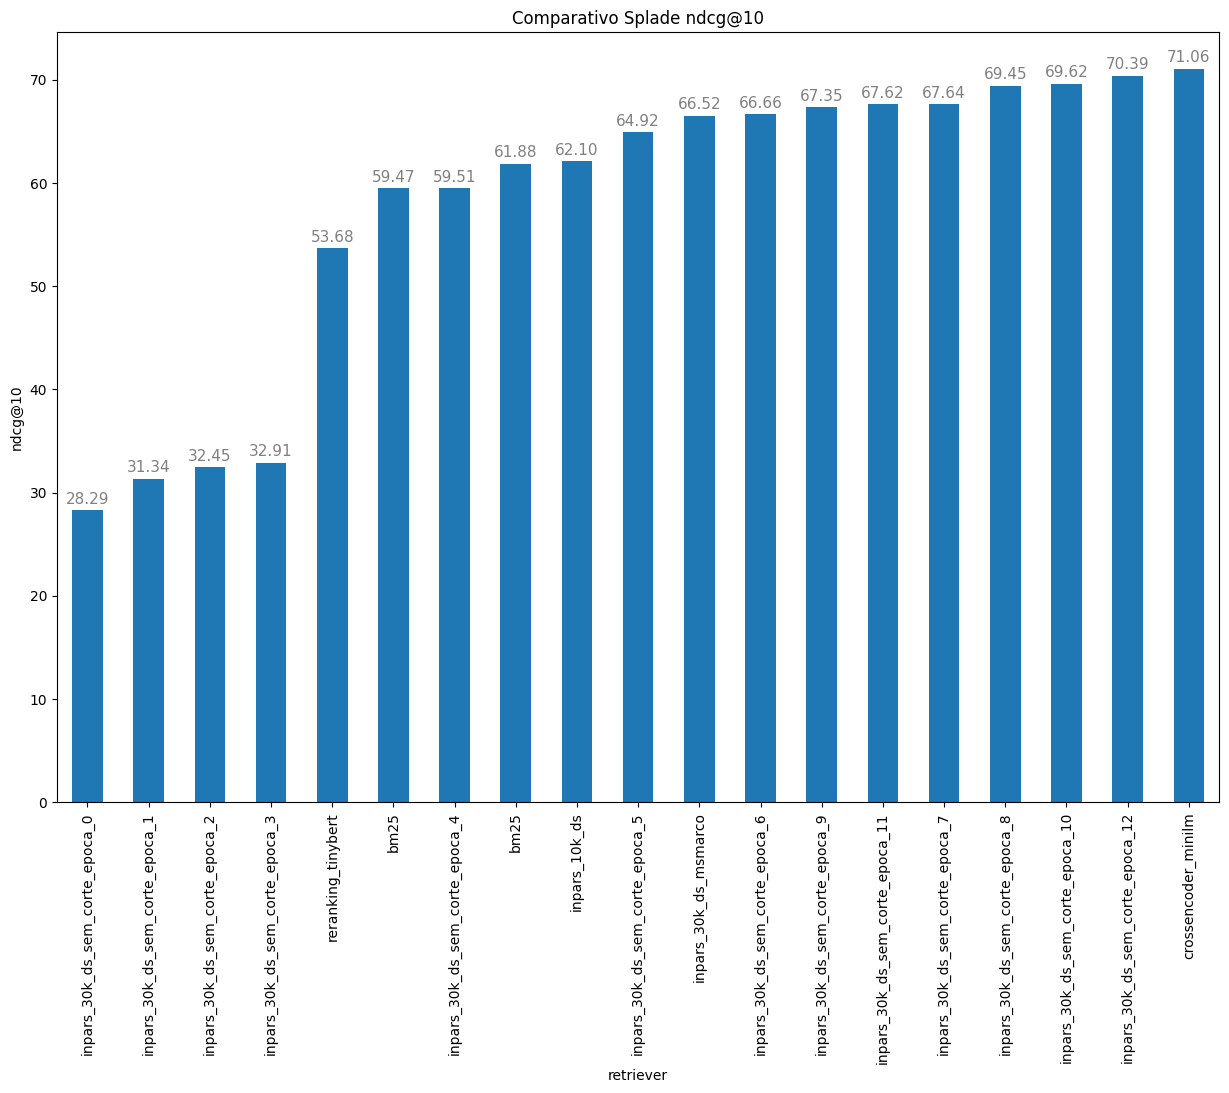

In [223]:

# Transforma a lista em um DataFrame
df = pd.DataFrame(lista_resultados)

# Ordena os valores de acordo com o ndcg
df = df.sort_values(by='ndcg', ascending=True)

# Plota o gráfico de barras
fig, ax = plt.subplots(figsize=(15, 10))
ax = df.plot(kind='bar', x='retriever', y='ndcg', rot=0, ax=ax)

# Adiciona os valores de ndcg acima das barras
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 8),
                textcoords='offset points')
# Configura os eixos e título do gráfico
ax.set_xticklabels(df['retriever'],rotation=90)
ax.set_title(f'Comparativo Splade ndcg@10')
ax.set_ylabel('ndcg@10')
ax.legend().set_visible(False)
plt.show()


In [141]:
df_reranking_entrada.columns

Index(['query', 'q0', 'docid', 'rank_estagio1', 'score_estagio1', 'query_text',
       'doc_text', 'score_tinybert', 'score_inpars_10k_ds',
       'score_inpars_30k_ds_msmarco', 'score_inpars_30k_ds_sem_corte_epoca_1'],
      dtype='object')

In [143]:
# Seleciona as colunas do dataframe original
cols = ['query', 'q0', 'docid', 'rank_estagio1', 'score_estagio1', 'query_text', 'doc_text']

# Cria uma lista para armazenar as linhas do novo dataframe
new_rows = []

# Itera sobre as linhas do dataframe original
for idx, row in df_reranking.iterrows():
    # Itera sobre as colunas que começam com "score_"
    for col in df_reranking.filter(regex='^score_'):
        # Obtém o nome do retriever a partir do nome da coluna
        retriever = col.replace('score_', '')
        # Cria uma nova linha com as informações da linha original e as colunas "score" e "retriever"
        new_row = row[cols].to_dict()
        new_row['score'] = row[col]
        new_row['retriever'] = retriever
        # Adiciona a nova linha à lista
        new_rows.append(new_row)

# Cria um novo dataframe com as linhas da lista
df_new = pd.DataFrame(new_rows)


In [144]:
df_new.shape

(200000, 9)

In [145]:

# Reordena as colunas do novo dataframe
df_new = df_new[['query', 'q0', 'docid', 'rank_estagio1', 'score_estagio1', 'query_text', 'doc_text', 'score', 'retriever']]



In [146]:
df_new.shape

(200000, 9)

In [147]:
df_new.head()

,query,q0,docid,rank_estagio1,score_estagio1,query_text,doc_text,score,retriever
0,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,3.895198,estagio1
1,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,0.183529,tinybert
2,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,0.999184,inpars_10k_ds
3,1,q0,jeuwaj50,226,3.895198,what is the origin of COVID-19,COVID-19—What we know and what we need to know...,0.998415,inpars_30k_ds_msmarco
4,1,q0,9puijlym,874,3.389897,what is the origin of COVID-19,What is the role of rheumatologists in the era...,3.389897,estagio1


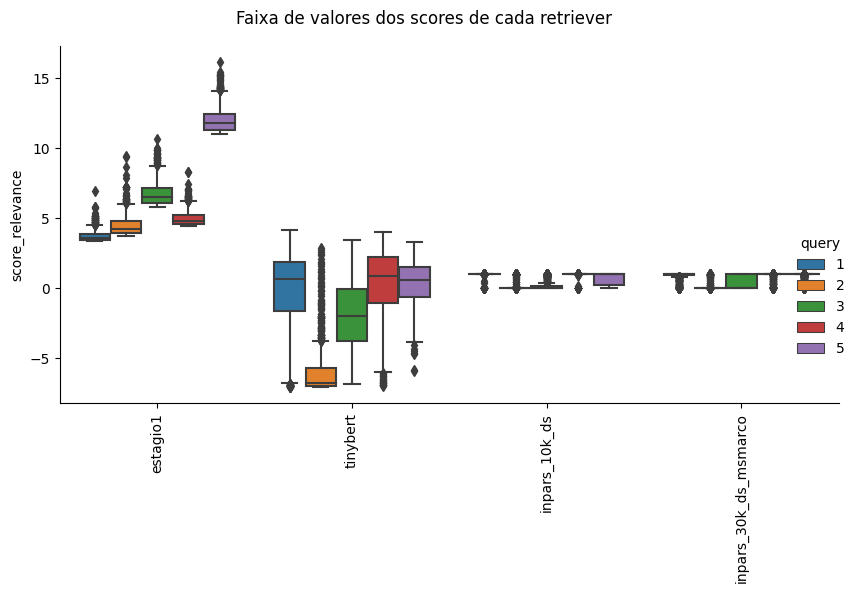

In [201]:
g = sns.catplot(x="retriever", sharex=True, y="score", hue='query',
                kind="box", data=df_new[df_new['query']<=5], height=6, aspect=20/15) # row="CLASSE", 
g.fig.suptitle('Faixa de valores dos scores de cada retriever')
g.set_xticklabels(rotation=90)
g.set_axis_labels("", 'score_relevance')
#g.fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.show()


In [155]:
from sklearn.preprocessing import MinMaxScaler

In [156]:
df_reranking_norm = df_reranking.copy()

In [165]:
df_reranking = df_reranking_norm.copy()

In [166]:
# Selecionar as colunas que começam com "score_"
score_cols = [col for col in df_reranking.columns if col.startswith('score_')]

# Normalizar as colunas selecionadas
scaler = MinMaxScaler()
df_reranking_norm[score_cols] = scaler.fit_transform(df_reranking[score_cols])


In [167]:
# Seleciona as colunas do dataframe original
cols = ['query', 'q0', 'docid', 'rank_estagio1', 'score_estagio1', 'query_text', 'doc_text']

# Cria uma lista para armazenar as linhas do novo dataframe
new_rows = []

# Itera sobre as linhas do dataframe original
for idx, row in df_reranking_norm.iterrows():
    # Itera sobre as colunas que começam com "score_"
    for col in df_reranking_norm.filter(regex='^score_'):
        # Obtém o nome do retriever a partir do nome da coluna
        retriever = col.replace('score_', '')
        # Cria uma nova linha com as informações da linha original e as colunas "score" e "retriever"
        new_row = row[cols].to_dict()
        new_row['score'] = row[col]
        new_row['retriever'] = retriever
        # Adiciona a nova linha à lista
        new_rows.append(new_row)

# Cria um novo dataframe com as linhas da lista
df_new_norm = pd.DataFrame(new_rows)


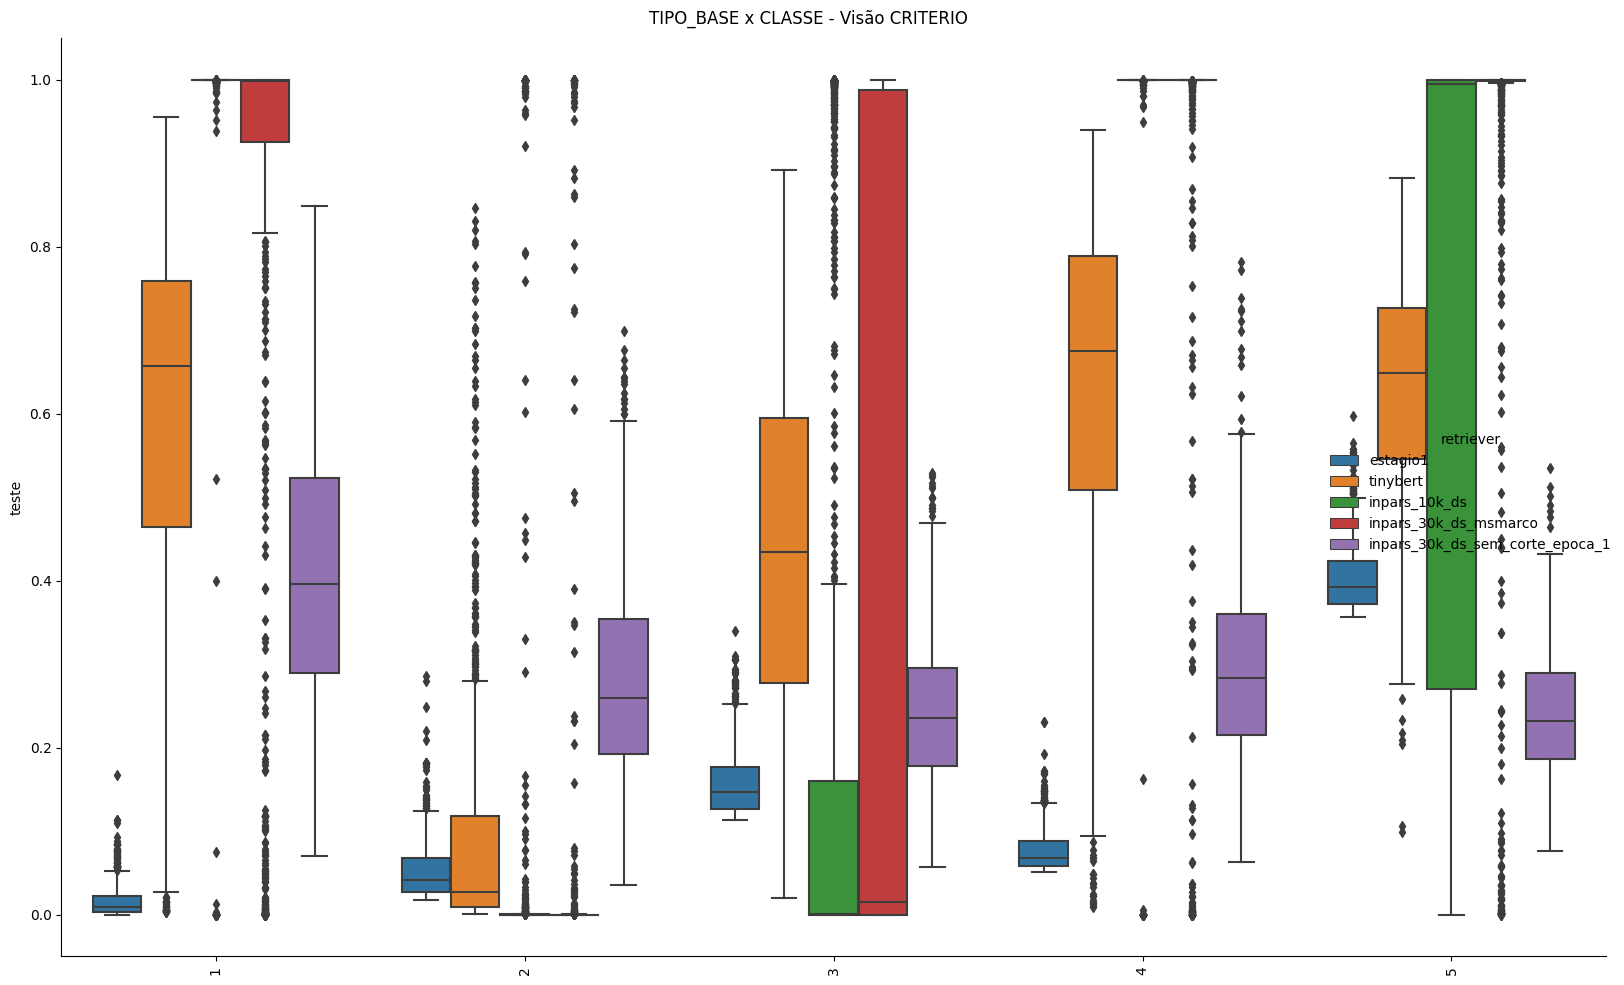

In [168]:
g = sns.catplot(x="query", sharex=True, y="score", hue='retriever',
                kind="box", data=df_new_norm[df_new_norm['query']<=5], height=10, aspect=20/15) # row="CLASSE", 
g.fig.suptitle('TIPO_BASE x CLASSE - Visão CRITERIO')
g.set_xticklabels(rotation=90)
g.set_axis_labels("", 'teste')
plt.tight_layout()
plt.show()

Testar sem shift no exemplo negativo e para épocas 1, 2 e 3

In [ ]:
df_reranking_entrada.to_csv(f"{DIRETORIO_TRABALHO}/df_reranking.csv")

In [ ]:
with open(PATH_LISTA_RESULTADO, 'wb') as outputFile:
    pickle.dump(lista_resultados, outputFile, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(PATH_LISTA_RESULTADO, 'rb') as f:
    lista_resultados = pickle.load(f)